In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.impute import  SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error
import pickle
from IPython.display import display, HTML
from sklearn.feature_selection import SelectKBest, f_regression

sns.set()

## based on https://github.com/sacharya225/data-expts/blob/master/Health%20Insurance%20Cost%20Prediction/Insurance_Charge_Regression_Prediction.ipynb

- This dataset can be found on Kaggle at: https://www.kaggle.com/datasets/mirichoi0218/insurance?resource=download.
- We want to predict the insurance charges.

### Importing dataset and dealing with Nulls

In [49]:
df = pd.read_csv('data.csv')

print(df.shape)
df.head()

(1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.900,0,yes,southwest,16884.92400
1,18.0,male,33.770,1,no,southeast,1725.55230
2,28.0,male,33.000,3,no,southeast,4449.46200
3,33.0,male,22.705,0,no,northwest,21984.47061
4,32.0,male,28.880,0,no,northwest,3866.85520


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1334 non-null   float64
 1   sex       1338 non-null   object 
 2   bmi       1336 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 73.3+ KB


- Wee see that age and bmi have 4 and 2 null values.

In [50]:
df.isnull().sum().sort_values(ascending=False)

age         4
bmi         2
sex         0
children    0
smoker      0
region      0
charges     0
dtype: int64

- Sklearn’s SimpleImputer allows you to replace missing values based on mean/median/most frequent values in the respective columns. In this example, I am using the median to fill null values.

In [51]:
from sklearn.impute import SimpleImputer

#Instantiate SimpleImputer 
si = SimpleImputer(missing_values = np.nan, strategy="median")
si.fit(df[['age', 'bmi']])
  
#Filling missing data with median
df[['age', 'bmi']] = si.transform(df[['age', 'bmi']])

In [52]:
df.isnull().sum().sort_values(ascending=False)

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

### Data visualization

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'children'}>,
        <Axes: title={'center': 'charges'}>]], dtype=object)

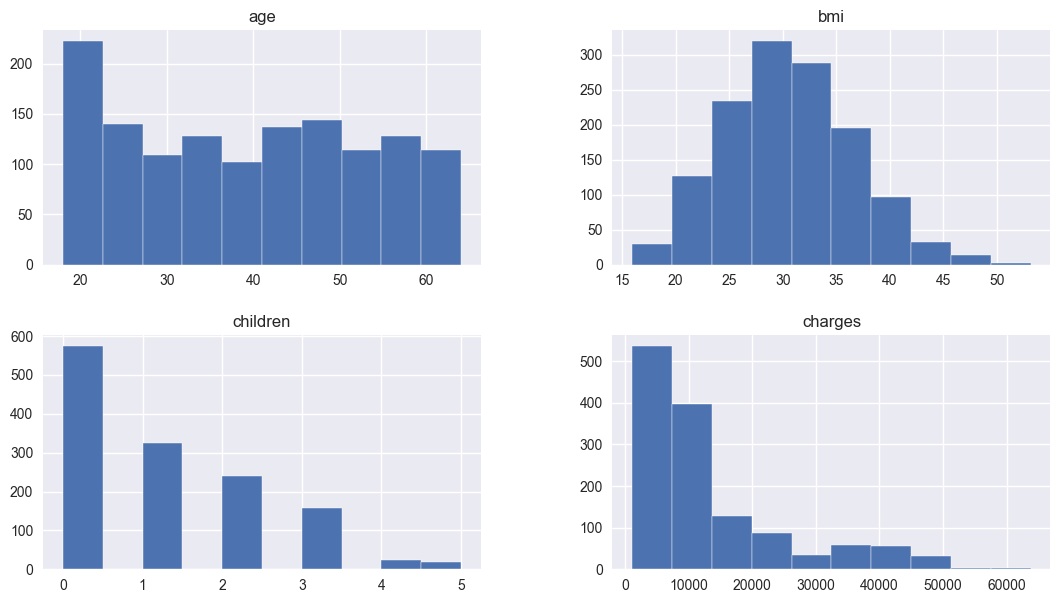

In [53]:
df.hist(figsize=(13,7))

In [11]:
df1 = df[['age', 'bmi', 'children', 'charges']]

<Axes: >

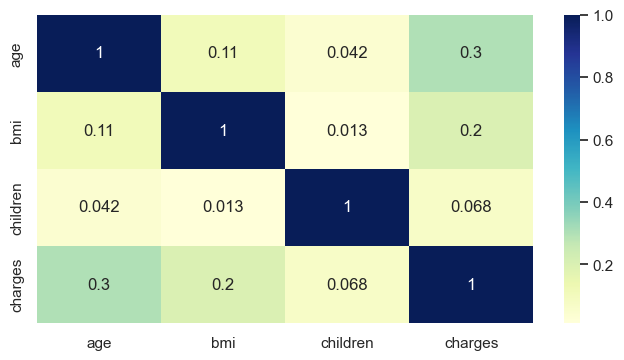

In [16]:
plt.figure(figsize=(8,4))
sns.heatmap(df1.corr(), annot=True, cmap="YlGnBu")

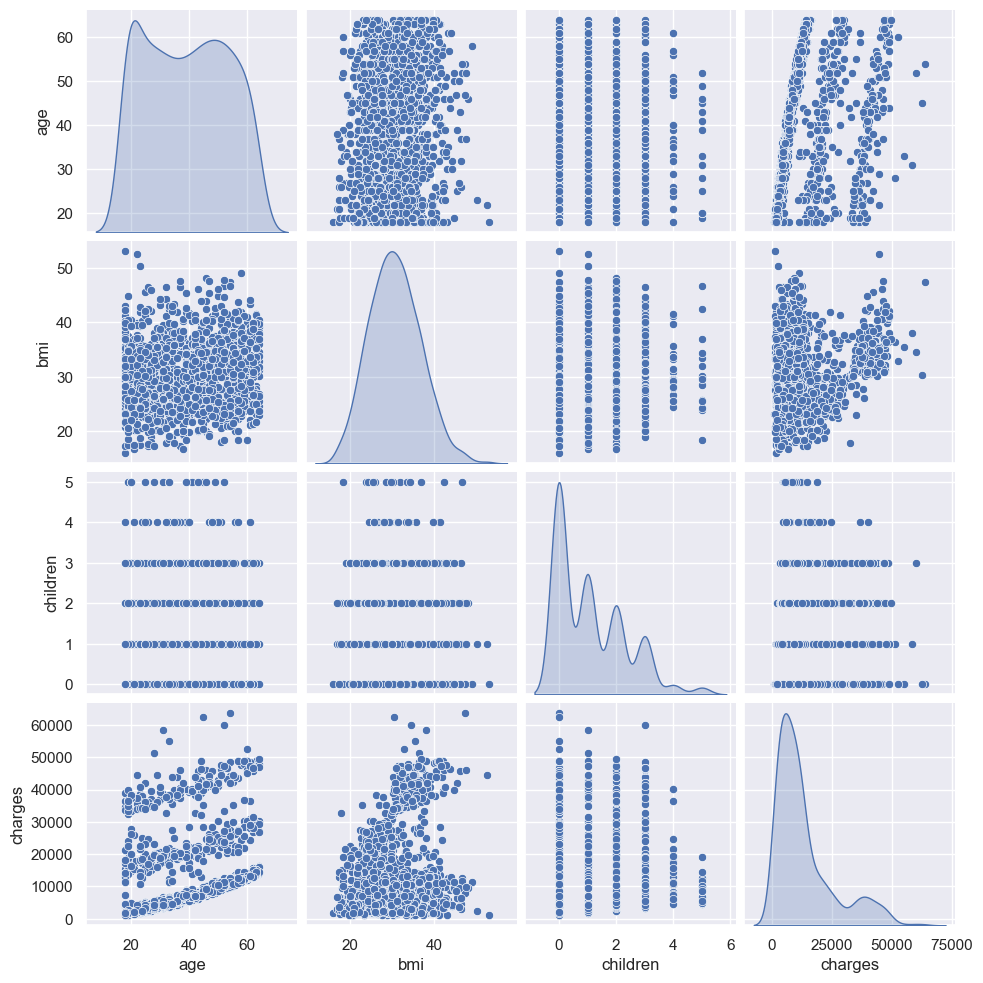

In [17]:
sns.pairplot(data=df1, diag_kind='kde')

- Let us add Kernel Density Estimates (KDE) to our plots, and only plot on the lower part, to avoid redundant plots.

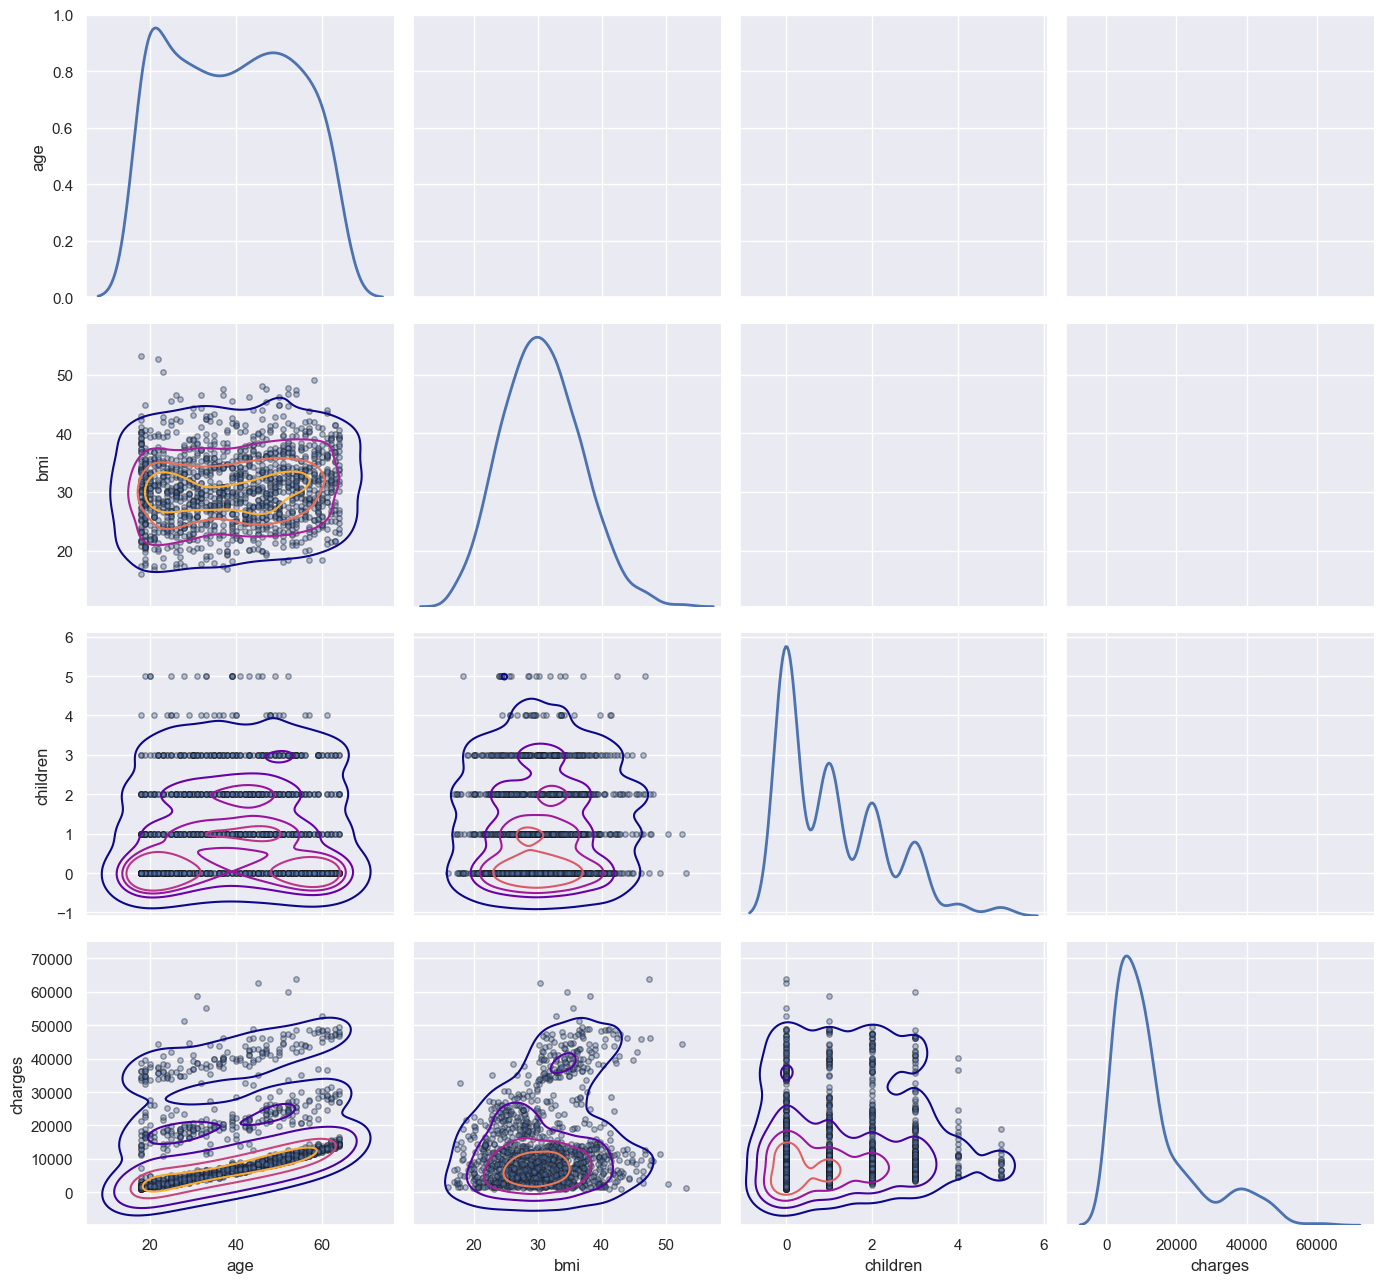

In [19]:
def snsPairGrid(df):
    g = sns.PairGrid(df, diag_sharey=False)
    g.fig.set_size_inches(14,13)
    g.map_diag(sns.kdeplot, lw=2) # draw kde approx on the diagonal
    g.map_lower(sns.scatterplot, s=15, edgecolor="k", linewidth=1,alpha=0.4)
    g.map_lower(sns.kdeplot, cmap='plasma', n_levels=5) # kde approx
    plt.tight_layout()
    
snsPairGrid(df1)

In [10]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.205531,30.663472,1.094918,13270.422265
std,14.049929,6.098183,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


- What do we see?

1. Distributions for Charges and children are skewed.
2. BMI and Age show a positive correlation with Charges.
3. BMI follows something thar resembles a normal distribution! 

- What about relations between charges and other variables? With the non-categorical variables, there are no strongly correlated features, but Age and BMI look like features that could be useful later!

- Seaborn’s boxplot and countplot can be used to bring out the impact of categorical variables on charges.

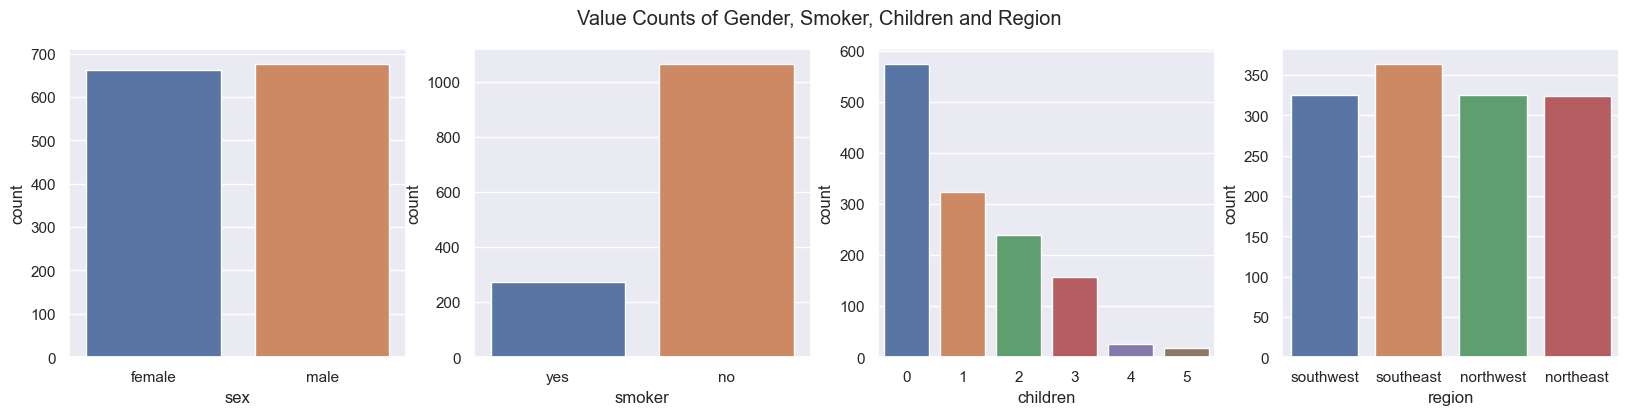

In [20]:
fig, ax2 = plt.subplots(1,4,  figsize=(20,4))
fig.suptitle('Value Counts of Gender, Smoker, Children and Region')

sns.countplot(ax=ax2[0], x=df.sex)
sns.countplot(ax=ax2[1], x=df.smoker)
sns.countplot(ax=ax2[2], x=df.children)
sns.countplot(ax=ax2[3], x=df.region)

plt.show()

- Number of males and females is roughly the same.
- There are significantly less smokers in the dataset.
- The distribution for the number of children is left-skewed.
- Distribution across regions is uniform.

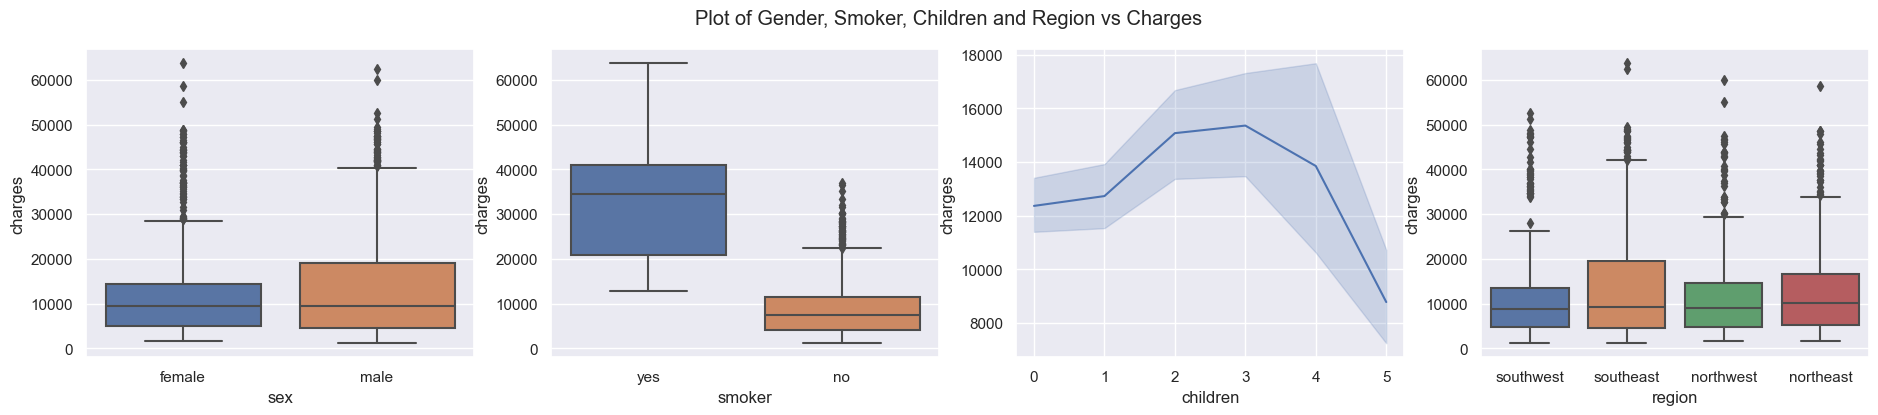

In [21]:
fig, ax2 = plt.subplots(1,4,  figsize=(23,4))
fig.suptitle('Plot of Gender, Smoker, Children and Region vs Charges')

sns.boxplot(ax=ax2[0], x=df.sex, y=df.charges)
sns.boxplot(ax=ax2[1], x=df.smoker, y=df.charges)
sns.lineplot(ax=ax2[2], x=df.children, y=df.charges)
sns.boxplot(ax=ax2[3], x=df.region, y=df.charges)
plt.show()

- Percentage of males and females are almost the same and On average median charges of male and female are also same, but males have higher range of charges. 
- Smokers have higher average and higher range of charges compared to non-smokers.
- The charges mean is independent of the region, but the range might differ from region to region.

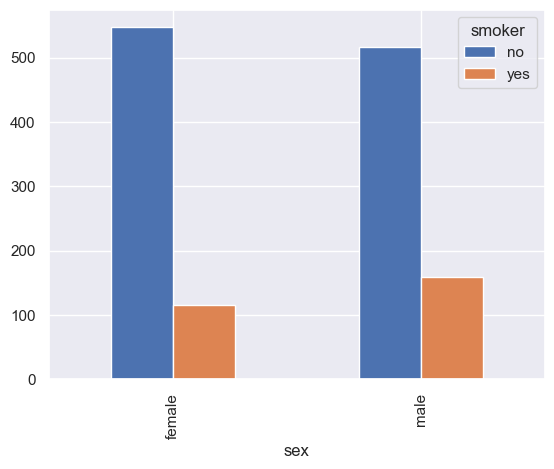

In [22]:
pd.crosstab(df.sex, df.smoker).plot(kind="bar")
plt.show()

- Percentage of female smokers is less than the percentage of male smokers

### Base model 1 - Linear Regression 

In [54]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [55]:
X, y = df.drop(['smoker', 'region', 'charges', 'sex'], axis=1), df['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
# define model
model = LinearRegression()
model.fit(X_train, y_train)

# evaluate the model
yhat = model.predict(X_test)

print(r2_score(y_train, model.predict(X_train))) # checking overfitting
r2_score(y_test, yhat), mean_absolute_error(y_test, yhat), np.sqrt(mean_squared_error(y_test, yhat))

0.10991038826041888


(0.15491042327727977, 9181.385064544615, 11454.21689960174)

In [57]:
# R^2 coefficient
print([model.score(X_train, y_train), model.score(X_test, y_test)])

[0.10991038826041888, 0.15491042327727977]


In [58]:
residual = y_test - yhat
residual.shape

(268,)

Text(0.5, 0, 'yhat Predicted values')

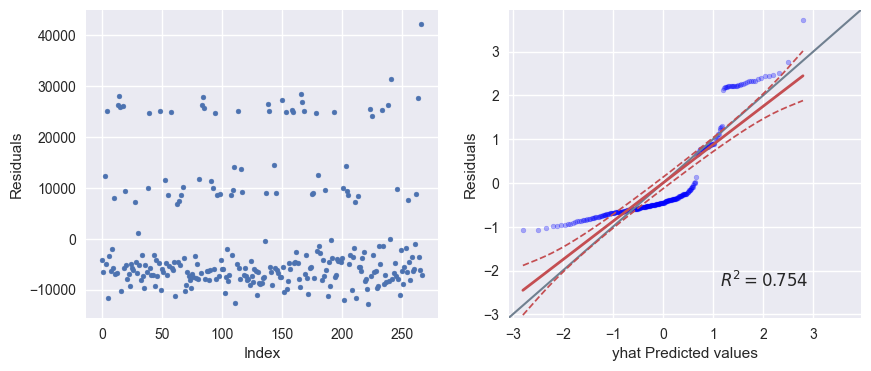

In [59]:
fig, axes = plt.subplots(1,2,figsize=(10,4))

axes[0].scatter([i for i in range(268)], residual, marker='.')
pg.qqplot(residual, dist='norm', confidence=.95, marker=".", ax=axes[1], square=False, alpha=0.3)

axes[1].scatter(yhat, residual, marker='.')

axes[0].set_ylabel('Residuals')
axes[0].set_xlabel('Index')

axes[1].set_ylabel('Residuals')
axes[1].set_xlabel('yhat Predicted values')



- Clearly the base linear model is NOT great!
- Let's check how features were used for predicting the model:

<BarContainer object of 3 artists>

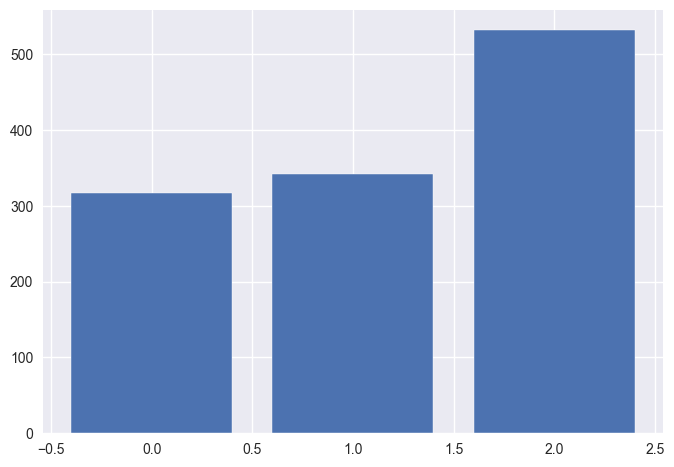

In [60]:
# compute with statsmodels, by adding intercept manually
import statsmodels.api as sm
X1_test = sm.add_constant(X_test)
result = sm.OLS(y_test, X1_test).fit()

#print dir(result)
plt.bar([i for i in range(3)], result.params[1:])

In [61]:
result.params[1:]

age         316.373344
bmi         341.573237
children    531.889618
dtype: float64

In [62]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     17.67
Date:                Sun, 04 Jun 2023   Prob (F-statistic):           1.74e-10
Time:                        18:31:07   Log-Likelihood:                -2883.1
No. Observations:                 268   AIC:                             5774.
Df Residuals:                     264   BIC:                             5788.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.042e+04   3921.966     -2.656      0.008   -1.81e+04   -2693.943
age          316.3733     50.415      6.275      0.000     217.106     415.640
bmi          341.5732    111.971      3.051      0.003     121.103     562.043
children     531.8896    605.516      0.878      0.381    -660.365    1724.144
==============================================================================
Omnibus:                       67.307   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              111.655
Skew:                           1.486   Prob(JB):                     5.68e-25
Kurtosis:                       4.078   Cond. No.                         286.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

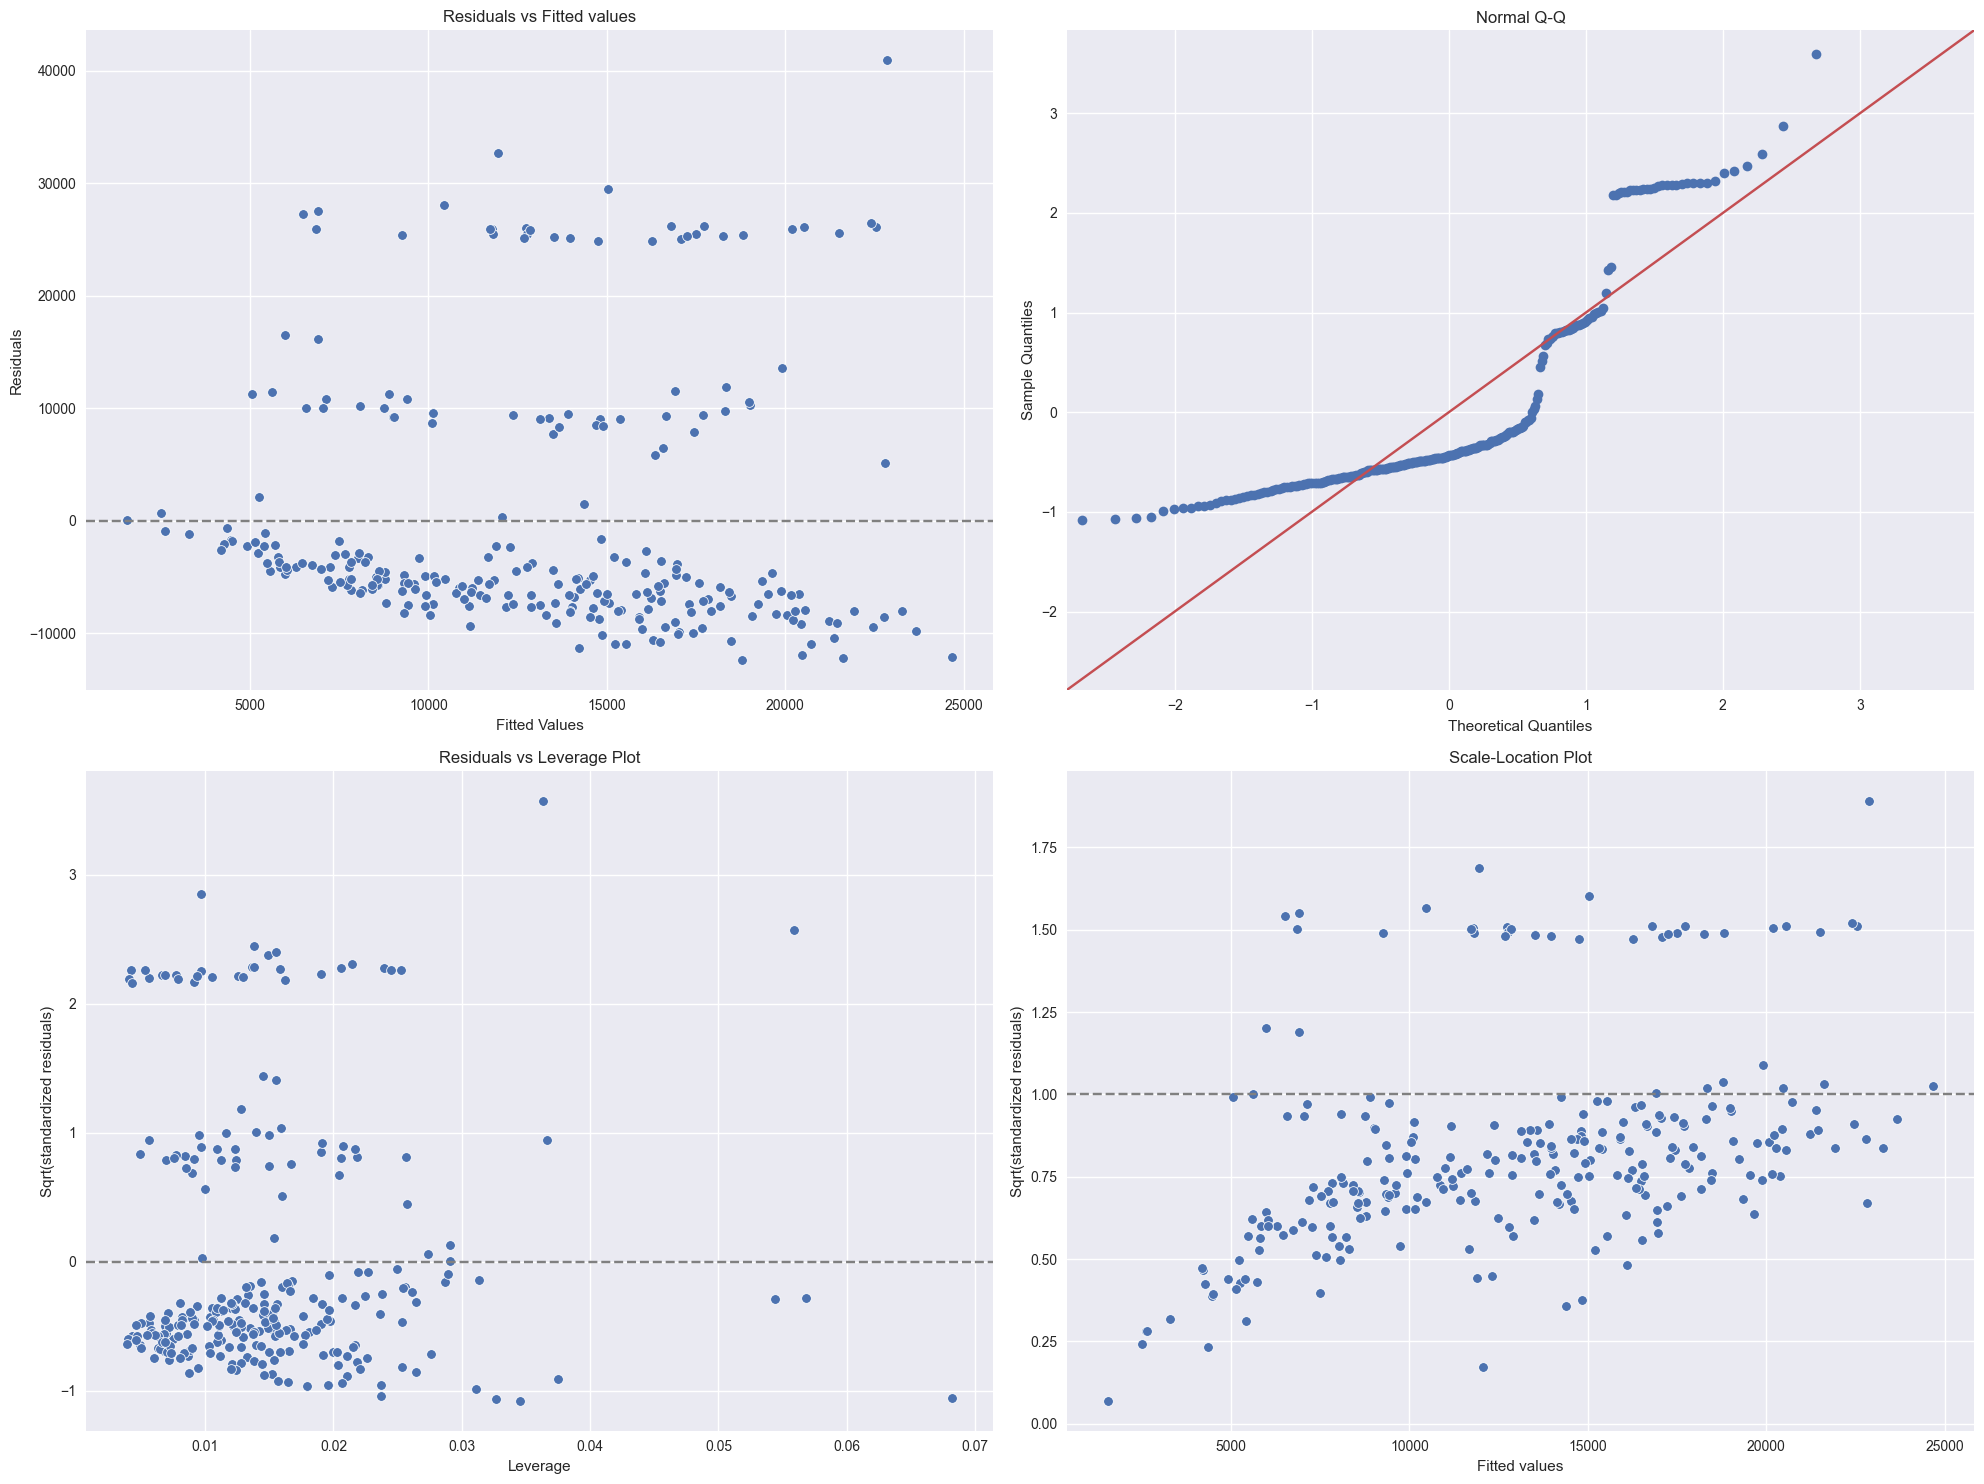

In [63]:
import statsmodels.formula.api as smf
  
# Get different Variables for diagnostic
residuals = result.resid
fitted_value = result.fittedvalues
stand_resids = result.resid_pearson
influence = result.get_influence()
leverage = influence.hat_matrix_diag
  
# PLot different diagnostic plots
#plt.rcParams["figure.figsize"] = (20,15)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,15))  
plt.style.use('seaborn')
  
# Residual vs Fitted Plot
sns.scatterplot(x=fitted_value, y=residuals, ax=ax[0, 0])
ax[0, 0].axhline(y=0, color='grey', linestyle='dashed')
ax[0, 0].set_xlabel('Fitted Values')
ax[0, 0].set_ylabel('Residuals')
ax[0, 0].set_title('Residuals vs Fitted values')
  
# Normal Q-Q plot
sm.qqplot(residuals, fit=True, line='45',ax=ax[0, 1], c='#4C72B0')
ax[0, 1].set_title('Normal Q-Q')
  
 
# Residual vs Leverage Plot
sns.scatterplot(x=leverage, y=stand_resids, ax=ax[1, 0])
ax[1, 0].axhline(y=0, color='grey', linestyle='dashed')
ax[1, 0].set_xlabel('Leverage')
ax[1, 0].set_ylabel('Sqrt(standardized residuals)')
ax[1, 0].set_title('Residuals vs Leverage Plot')

# Scale-Location Plot
sns.scatterplot(x=fitted_value, y=np.sqrt(np.abs(stand_resids)), ax=ax[1, 1])
ax[1, 1].axhline(y=1, color='grey', linestyle='dashed')
ax[1, 1].set_xlabel('Fitted values')
ax[1, 1].set_ylabel('Sqrt(standardized residuals)')
ax[1, 1].set_title('Scale-Location Plot')
  

plt.tight_layout()
plt.show()

### Other Base models

Let us quickly run some other base models and see their outputs:
- Polynomial Fit
- Decision Tree Regressor
- Random Forest Regressor
- AdaBoost Regressor
- Gradient Boost
- XGBoost

In [64]:
dict = {}

In [68]:
def get_scores(predictions, true):
    MAE = np.mean(abs(predictions-true))
    RMSE = np.sqrt(np.mean((predictions-true)**2))
    R2 = 1 - np.sum((predictions-true)**2)/np.sum((true-np.mean(true))**2)
    
    return MAE, RMSE, R2

In [69]:
from sklearn.preprocessing import PolynomialFeatures

trans = PolynomialFeatures(degree=2, include_bias=False)
trans.fit(X_train)
X_train_new = trans.transform(X_train)
X_test_new = trans.transform(X_test)

reg = LinearRegression()
reg.fit(X_train_new, y_train)

y_pred = reg.predict(X_test_new)


dict['Polynomial (2) Regressor'] =  get_scores(y_pred, y_test)
print(dict['Polynomial (2) Regressor'])

print([reg.score(X_train_new, y_train), reg.score(X_test_new, y_test)])  # checking overfitting

(9165.807093419882, 11527.362381519055, 0.14408264597059306)
[0.11975930960416081, 0.14408264597059306]


In [72]:
from sklearn import tree

reg = tree.DecisionTreeRegressor().fit(X_train, y_train)
y_pred = reg.predict(X_test)

dict['Decision Tree Regressor'] = get_scores(y_pred, y_test)
print(dict['Decision Tree Regressor'] )

print([reg.score(X_train, y_train), reg.score(X_test, y_test)])  # Terrible model! Clearly overfits training data!

(10802.07686547015, 17636.472949680017, -1.0035279845186817)
[0.9874092027351584, -1.0035279845186817]


In [73]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor().fit(X_train, y_train)
y_pred = reg.predict(X_test)

dict['Random Forest Regressor'] = get_scores(y_pred, y_test)
print(dict['Random Forest Regressor'])

print([reg.score(X_train, y_train), reg.score(X_test, y_test)]) #still overfits, but much better than a decision tree

(9197.278131656154, 12479.492458425319, -0.0031497875919639373)
[0.8419843900376438, -0.0031497875919639373]


In [75]:
from sklearn.ensemble import AdaBoostRegressor

reg = AdaBoostRegressor(random_state = 0, n_estimators = 100).fit(X_train, y_train)
y_pred = reg.predict(X_test)

dict['AdaBoost Regressor'] = get_scores(y_pred, y_test)
print(dict['AdaBoost Regressor'])

print([reg.score(X_train, y_train), reg.score(X_test, y_test)]) # as good as a constant fit :)

(11086.43733325367, 12393.656035165408, 0.010602480020062477)
[0.005974969446841394, 0.010602480020062477]


In [77]:
from sklearn.ensemble import GradientBoostingRegressor

reg = GradientBoostingRegressor(n_estimators = 100).fit(X_train, y_train)
y_pred = reg.predict(X_test)

dict['GradientBoosting Regressor'] = get_scores(y_pred, y_test)
print(dict['GradientBoosting Regressor'])

print([reg.score(X_train, y_train), reg.score(X_test, y_test)]) # Still not great

(9369.719634029327, 12058.073482354866, 0.06345684947787089)
[0.34656535489552676, 0.06345684947787089]


In [79]:
from xgboost import XGBRegressor

reg = XGBRegressor().fit(X_train, y_train)
y_pred = reg.predict(X_test)

dict['XGBoosting Regressor'] = get_scores(y_pred, y_test)
print(dict['XGBoosting Regressor'])

print([reg.score(X_train, y_train), reg.score(X_test, y_test)]) # Overfitting again!

(9309.269172728196, 13492.172097026587, -0.17256164444363864)
[0.9073749391307367, -0.17256164444363864]


- So, all our models with no parameter specification, apart from the linear regression, are as good as a constant fit, or even worse!

### Feature engineering and feature selection

We will do the same transformations to both train and test data. For simplicity, since our previous models were not great, we will do another test/train split later. We start be converting categorical variables to numeric form - One hot encoding.

In [80]:
region = pd.get_dummies(df.region, prefix='location')
region.head()

,location_northeast,location_northwest,location_southeast,location_southwest
0,False,False,False,True
1,False,False,True,False
2,False,False,True,False
3,False,True,False,False
4,False,True,False,False


In [81]:
df = pd.concat([df,region],axis=1)
df.drop(columns='region', inplace=True)

In [82]:
df.sex.replace(to_replace=['male', 'female'], value=[1,0], inplace=True)
df.smoker.replace(to_replace=['yes', 'no'], value=[1,0], inplace=True)
df.sample(3)

,age,sex,bmi,children,smoker,charges,location_northeast,location_northwest,location_southeast,location_southwest
356,46.0,1,43.89,3,0,8944.1151,False,False,True,False
413,25.0,1,23.90,5,0,5080.0960,False,False,False,True
499,62.0,0,39.20,0,0,13470.8600,False,False,False,True


<Axes: >

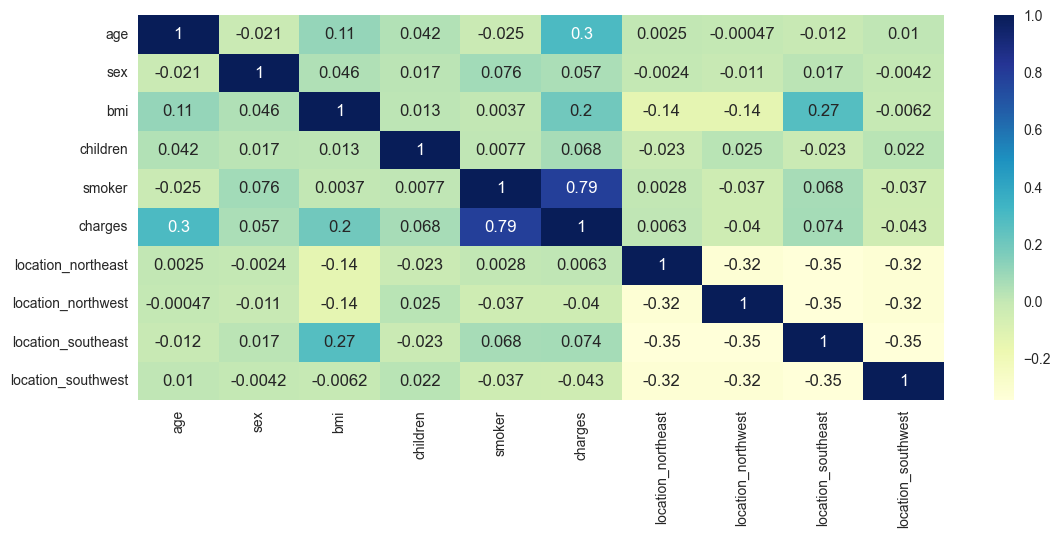

In [83]:
plt.figure(figsize=(13,5))
sns.heatmap(df.corr(), annot=True, cmap="YlGnBu")

- Based on the map, Smoker has a considerable impact on the insurance charges, while sex has the least impact and so we will drop this column in our feature list(X). We will now proceed towards model development where the first step is to select X and Y and split data into test and train sets.

In [85]:
#Creating and X and Y variables region_rank
y = df.charges.values
X = df[['age', 'bmi', 'smoker', 'children', 'location_northeast', 'location_northwest', 'location_southeast', 'location_southwest']]

#Split data into test and train
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2, random_state=42)

- Standardize numeric features by removing the mean and scaling to unit variance. This can be done using the sklearn StandardScaler.

In [86]:
from sklearn.preprocessing import RobustScaler, StandardScaler
numeric = ['age', 'bmi', 'children']
sc = StandardScaler()
X_train[numeric] = sc.fit_transform(X_train[numeric])
X_test[numeric] = sc.transform(X_test[numeric])

### Trying now with the new features - still no parameter selection!

In [88]:
dict1 = {}

In [116]:
# define model
reg = LinearRegression()
reg.fit(X_train, y_train)

# evaluate the model
yhat = reg.predict(X_test)

dict1['Linear Regressor'] =  get_scores(y_pred, y_test)
print(dict1['Linear Regressor'])

print([reg.score(X_train, y_train), reg.score(X_test, y_test)])  # This is already much better!

(3255.699611011724, 6424.105082560156, 0.7341741493458706)
[0.7413267635416543, 0.7823237227027419]


- The linear model is much better. Let us check its assumptions.

In [117]:
residual = y_test - y_pred
residual.shape

(268,)

Text(0.5, 0, 'yhat Predicted values')

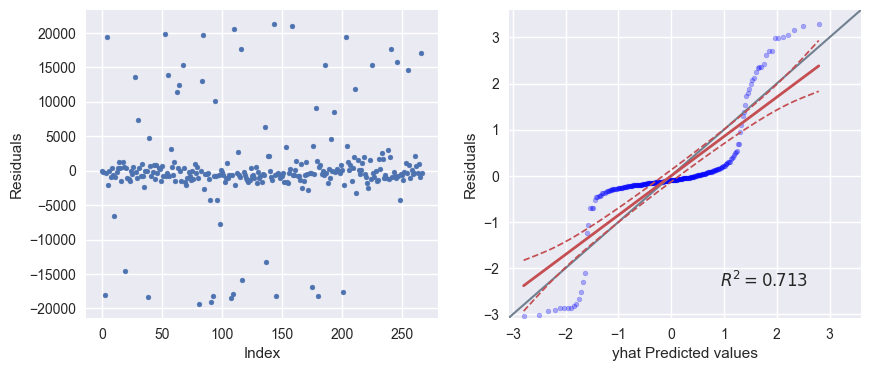

In [118]:
fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].scatter([i for i in range(268)], residual, marker='.')
pg.qqplot(residual, dist='norm', confidence=.95, marker=".", ax=axes[1], square=False, alpha=0.3)

axes[1].scatter(y_pred, residual, marker='.')
#axes[1][1].scatter(X_test[:,6-1], residual, marker='.')

#axes[0].set_xlim([-3, 3])
#axes[0].set_ylim([-3.5, 5])
axes[0].set_ylabel('Residuals')
axes[0].set_xlabel('Index')

axes[1].set_ylabel('Residuals')
axes[1].set_xlabel('yhat Predicted values')

- There is still an 'S-shape' in the QQ plot, suggesting that residuals do not follow a normal distributed.

In [91]:
from sklearn.preprocessing import PolynomialFeatures

trans = PolynomialFeatures(degree=2, include_bias=False)
trans.fit(X_train)
X_train_new = trans.transform(X_train)
X_test_new = trans.transform(X_test)

reg = LinearRegression()
reg.fit(X_train_new, y_train)

y_pred = reg.predict(X_test_new)


dict1['Polynomial (2) Regressor'] =  get_scores(y_pred, y_test)
print(dict1['Polynomial (2) Regressor'])

print([reg.score(X_train_new, y_train), reg.score(X_test_new, y_test)])  # Amazing!

(2686.7694378694027, 4504.796871675868, 0.8692859216299876)
[0.8404662626370222, 0.8692859216299876]


In [93]:
from sklearn import tree

reg = tree.DecisionTreeRegressor().fit(X_train, y_train)
y_pred = reg.predict(X_test)

dict1['Decision Tree Regressor'] = get_scores(y_pred, y_test)
print(dict1['Decision Tree Regressor'] )

print([reg.score(X_train, y_train), reg.score(X_test, y_test)])  # This is much better than before, but clearly still overfits.

(2781.3349635410445, 6131.345313965427, 0.7578505473258708)
[0.9983062641352847, 0.7578505473258708]


In [154]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor().fit(X_train, y_train)
y_pred = reg.predict(X_test)

dict1['Random Forest Regressor'] = get_scores(y_pred, y_test)
print(dict1['Random Forest Regressor'])

print([reg.score(X_train, y_train), reg.score(X_test, y_test)]) #still overfits, but better than a decision tree

(2482.9765241048826, 4533.254485632055, 0.8676292164577712)
[0.9758997393634448, 0.8676292164577712]


In [96]:
from sklearn.ensemble import AdaBoostRegressor

reg = AdaBoostRegressor(random_state = 0, n_estimators = 100).fit(X_train, y_train)
y_pred = reg.predict(X_test)

dict1['AdaBoost Regressor'] = get_scores(y_pred, y_test)
print(dict1['AdaBoost Regressor'])

print([reg.score(X_train, y_train), reg.score(X_test, y_test)]) # awesome, no overfitting

(4678.060732535409, 5581.696738900512, 0.7993198515331927)
[0.8125292594132476, 0.7993198515331927]


In [155]:
from sklearn.ensemble import GradientBoostingRegressor

reg = GradientBoostingRegressor(n_estimators = 100).fit(X_train, y_train)
y_pred = reg.predict(X_test)

dict1['GradientBoosting Regressor'] = get_scores(y_pred, y_test)
print(dict1['GradientBoosting Regressor'])

print([reg.score(X_train, y_train), reg.score(X_test, y_test)]) # Pretty great

(2412.620911579604, 4350.7116197195, 0.8780750643430199)
[0.8983903773669399, 0.8780750643430199]


In [156]:
from xgboost import XGBRegressor

reg = XGBRegressor().fit(X_train, y_train)
y_pred = reg.predict(X_test)

dict1['XGBoosting Regressor'] = get_scores(y_pred, y_test)
print(dict1['XGBoosting Regressor'])

print([reg.score(X_train, y_train), reg.score(X_test, y_test)]) # Similar results to a random forest

(2676.548407011303, 4879.324756300362, 0.8466473133230905)
[0.9916475166337265, 0.8466473133230905]


In [104]:
pd.DataFrame.from_dict(dict1)

,Linear Regressor,Polynomial (2) Regressor,Decision Tree Regressor,Random Forest Regressor,AdaBoost Regressor,XGBoosting Regressor
0,2676.548407,2686.769438,2781.334964,2465.887449,4678.060733,2676.548407
1,4879.324756,4504.796872,6131.345314,4562.135517,5581.696739,4879.324756
2,0.846647,0.869286,0.757851,0.865937,0.799320,0.846647


- Overfitting issues can be avoided by specifying parameters.
- Before we do that, let us try a few more things with the data.

### Transforming target variable 

- We have seen that charges data has a skewed distribution.
- We can do a Quantile Transform on the charges data. We do this using the QuantileTransformer of sklearn.
- However, since we transorm the target data, we use the TransformedTargetRegressor function of sklearn.

In [105]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer

In [111]:
# define model
model = LinearRegression()

# transform target data with TransformedTargetRegressor
regr_trans = TransformedTargetRegressor(regressor=model, transformer=QuantileTransformer(output_distribution='normal'))
regr_trans.fit(X_train, y_train)

# evaluate the model
y_pred = regr_trans.predict(X_test)

print(get_scores(y_pred, y_test))
print([reg.score(X_train, y_train), reg.score(X_test, y_test)]) 

(3255.699611011724, 6424.105082560156, 0.7341741493458706)
[0.7413267635416543, 0.7823237227027419]


In [112]:
dict1['Linear Regressor']

(2676.548407011303, 4879.324756300362, 0.8466473133230905)

- This actually makes it worse!

In [113]:
residual = y_test - y_pred
residual.shape

(268,)

Text(0.5, 0, 'yhat Predicted values')

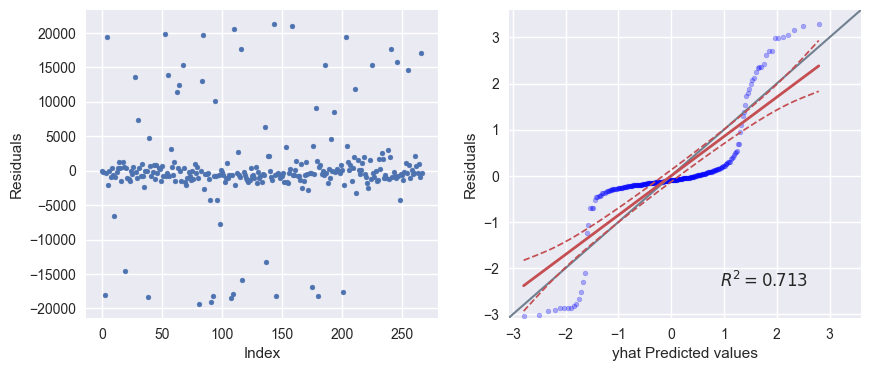

In [114]:
fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].scatter([i for i in range(268)], residual, marker='.')
pg.qqplot(residual, dist='norm', confidence=.95, marker=".", ax=axes[1], square=False, alpha=0.3)

axes[1].scatter(y_pred, residual, marker='.')
#axes[1][1].scatter(X_test[:,6-1], residual, marker='.')

#axes[0].set_xlim([-3, 3])
#axes[0].set_ylim([-3.5, 5])
axes[0].set_ylabel('Residuals')
axes[0].set_xlabel('Index')

axes[1].set_ylabel('Residuals')
axes[1].set_xlabel('yhat Predicted values')

- The S-shape is now even more pronounced. Typically, such shapes appear when the distribution of the residuals is over-dispersed, so there is an increased number of outliers. This can be also seen in the residual plot. Hence, the quantile transformation to a normal distribution does not help the linear regressor.
- This feature is even more obvious when using a quantile transformation to a uniform distribution!

In [121]:
# define model
model = LinearRegression()

# transform target data with TransformedTargetRegressor
regr_trans = TransformedTargetRegressor(regressor=model, transformer=QuantileTransformer(output_distribution='uniform'))
regr_trans.fit(X_train, y_train)

# evaluate the model
y_pred = regr_trans.predict(X_test)

print(get_scores(y_pred, y_test))
print([reg.score(X_train, y_train), reg.score(X_test, y_test)]) 

(4711.341712193903, 8973.24289317751, 0.4813542935503642)
[0.7413267635416543, 0.7823237227027419]


In [122]:
residual = y_test - y_pred
residual.shape

(268,)

Text(0.5, 0, 'yhat Predicted values')

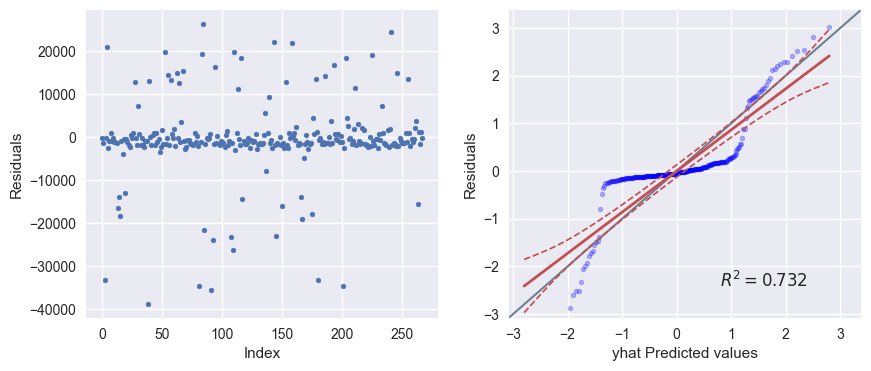

In [123]:
fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].scatter([i for i in range(268)], residual, marker='.')
pg.qqplot(residual, dist='norm', confidence=.95, marker=".", ax=axes[1], square=False, alpha=0.3)

axes[1].scatter(yhat, residual, marker='.')
#axes[1][1].scatter(X_test[:,6-1], residual, marker='.')

#axes[0].set_xlim([-3, 3])
#axes[0].set_ylim([-3.5, 5])
axes[0].set_ylabel('Residuals')
axes[0].set_xlabel('Index')

axes[1].set_ylabel('Residuals')
axes[1].set_xlabel('yhat Predicted values')

- We will simply use the charges as they are, without doing any transformation on them.

### Model Selection - choosing parameters

- Recall our previous results:

In [137]:
pd.DataFrame.from_dict(dict1)

,Linear Regressor,Polynomial (2) Regressor,Decision Tree Regressor,Random Forest Regressor,AdaBoost Regressor,XGBoosting Regressor
0,3255.699611,2686.769438,2781.334964,2465.887449,4678.060733,2676.548407
1,6424.105083,4504.796872,6131.345314,4562.135517,5581.696739,4879.324756
2,0.734174,0.869286,0.757851,0.865937,0.799320,0.846647


- We also had the following train/test scores:
1. [0.7413267635416543, 0.7823237227027419]
2. [0.8404662626370222, 0.8692859216299876]
3. [0.9983062641352847, 0.7578505473258708]
4. [0.9754095117488943, 0.8659371945956054]
5. [0.8125292594132476, 0.7993198515331927]
6. [0.8983903773669399, 0.8780750643430199]
7. [0.9916475166337265, 0.8466473133230905]

- So parameter selection would be very beneficial for models 3 (Decision Tree), 4 (Random Forest) and 7 (XGBoost), to avoid overfitting!
- Let's do this explicitly for a Random Forest! When using RandomForestRegressor, the returned fitted model has already been pruned. This happens under the hood in the sklearn implementation. Theoretically speaking too, a RandomForest is not just a combination of DecisionTrees, but is the pruned, aggregated, and using default settings, bootstrapped version of multiple large decision trees.
- That is, the overfitting is NOT due to pruning. To avoid over-fitting in random forest, the main thing you need to do is optimize a tuning parameter that governs the number of features that are randomly chosen to grow each tree from the bootstrapped data. For this we do a k-fold cross-validation, and choose the tuning parameter that minimizes test sample prediction error. In addition, growing a larger forest will improve predictive accuracy, although there are usually diminishing returns once you get up to several hundreds of trees.
- Note, however, that two of the appealing features of Random Forests are that it is difficult to overfit them and the default parameters are usually fairly good. 

In [146]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

In [144]:
print(X_train.shape, X_test.shape)

(1070, 8) (268, 8)


In [157]:
mean, std = [], [] # mean and std of cross-validation scores

for i in range(1,9):
    rf = RandomForestRegressor(max_features = i)
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1) # 5-fold validation
 # evaluate the model and collect the results
    scores = cross_val_score(rf, X_train, y_train, cv=cv, n_jobs=-1)
    mean.append(scores.mean())
    std.append(scores.std())


In [158]:
# keep a record of the values of alpha, mean accuracy rate, standard deviation of accuracies
eva_df = pd.DataFrame({'max_features': range(1,9), 'mean': mean, 'std': std})
eva_df = eva_df.sort_values(['mean'], ascending = False)
eva_df

,max_features,mean,std
3,4,0.836063,0.024954
4,5,0.835316,0.025106
2,3,0.834378,0.024987
5,6,0.833983,0.024864
6,7,0.831305,0.025598
7,8,0.829984,0.024458
1,2,0.816838,0.024635
0,1,0.788626,0.026766


In [160]:
dict2 = {}

In [169]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(max_features = 4).fit(X_train, y_train)
y_pred = reg.predict(X_test)

dict2['Random Forest Regressor'] = get_scores(y_pred, y_test)
print(dict2['Random Forest Regressor'])

print([reg.score(X_train, y_train), reg.score(X_test, y_test)]) #still overfits, but better than a decision tree

(2464.849956077581, 4444.084312956561, 0.8727855281592873)
[0.977001384034062, 0.8727855281592873]


- The model still overfits, but the performance is quite good regardless. We can try to change other parameters as well, and see if this changes anything.

### More Feature engineering?

- Can we create other features that might be more relevant for predicting 'charges'?

<Axes: >

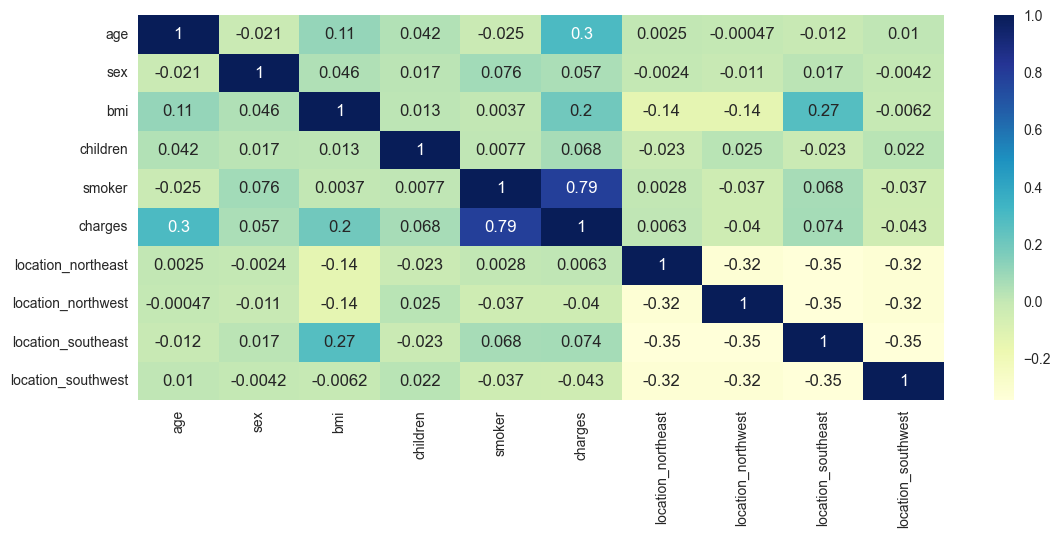

In [126]:
plt.figure(figsize=(13,5))
sns.heatmap(df.corr(), annot=True, cmap="YlGnBu")

- The geographical data, in particular, does not seem to be very relevant for predicting charges.
- Similarly, the 'children' data is not very relevant either.

In [128]:
df['location_north'] = df['location_northeast']+df['location_northwest']
df['location_south'] = df['location_southwest']+df['location_southeast']
df['more_than_1_child'] = df.children.apply(lambda x:1 if x>1 else 0)

In [131]:
df['location_west'] = df['location_southwest']+df['location_northwest']
df['location_east'] = df['location_southeast']+df['location_northeast']

In [132]:
df.head()

,age,sex,bmi,children,smoker,charges,location_northeast,location_northwest,location_southeast,location_southwest,location_north,location_south,more_than_1_child,location_west,location_east
0,19.0,0,27.900,0,1,16884.92400,False,False,False,True,False,True,0,True,False
1,18.0,1,33.770,1,0,1725.55230,False,False,True,False,False,True,0,False,True
2,28.0,1,33.000,3,0,4449.46200,False,False,True,False,False,True,1,False,True
3,33.0,1,22.705,0,0,21984.47061,False,True,False,False,True,False,0,True,False
4,32.0,1,28.880,0,0,3866.85520,False,True,False,False,True,False,0,True,False


<Axes: >

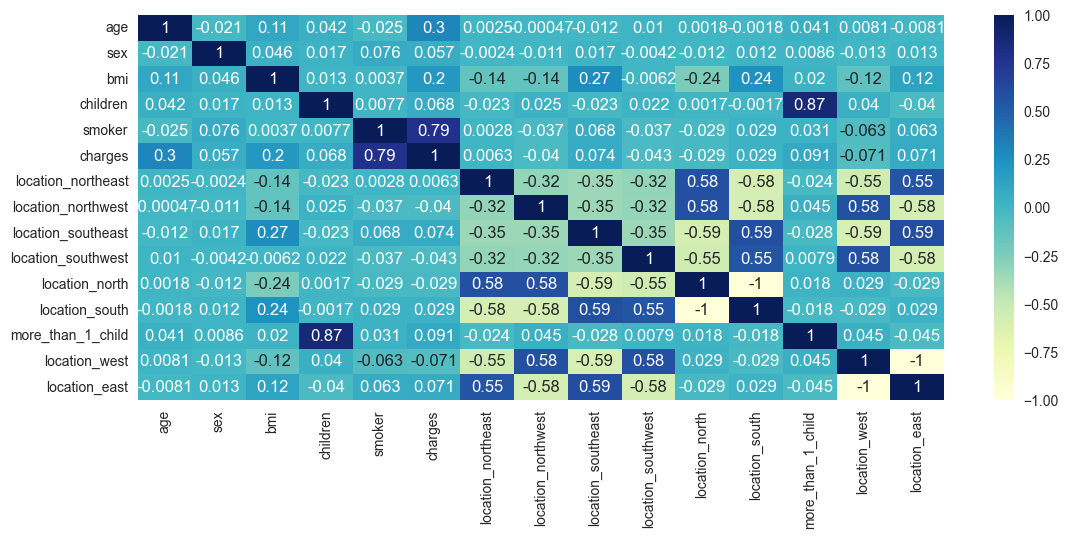

In [133]:
plt.figure(figsize=(13,5))
sns.heatmap(df.corr(), annot=True, cmap="YlGnBu")